# Traffic Sign Classifier with TensorFlow
-  Strcuture: Modified LeNet-5
- Dataset Source:

# Load The Data

In [1]:
#import
import pickle
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
# Load pickled data
import pickle

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(pd.unique(y_train))
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Index: 14979
38


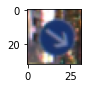

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))

plt.figure(figsize=(1,1))
plt.imshow(X_train[index], cmap="gray")
print("Index: {}".format(index))
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
x_min = X_train.min()
x_max = X_train.max()
X_train_std = (X_train - x_min)/(x_max - x_min)
X_valid_std = (X_valid - x_min)/(x_max - x_min)
X_test_std = (X_test - x_min)/(x_max - x_min)

229
0.8980392156862745


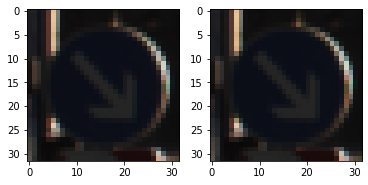

In [6]:
f, axarr = plt.subplots(1,2)
index = random.randint(0, len(X_train))
axarr[0].imshow(X_train[index])
axarr[1].imshow(X_train_std[index])
print(np.max(X_train[index]))
print(np.max(X_train_std[index]))

### Model Architecture

In [7]:
# Input variable
#Input image batch
x = tf.placeholder(tf.float32, (None, 32, 32, 3))

#Input label batch
y = tf.placeholder(tf.int32, (None))

#Encoding 
one_hot_y = tf.one_hot(y, 43)

In [8]:
#Main structure: LeNet
def LeNet(x, w_mu = 0, b_mu = 0.05, sigma = 0.05, keep_prob = 1):
    F_W = {
        "c1": tf.Variable(tf.truncated_normal([5, 5, 3, 10], mean = w_mu, stddev = sigma)),
        "c2": tf.Variable(tf.truncated_normal([5, 5, 10, 18], mean = w_mu, stddev = sigma)),
        "c3": tf.Variable(tf.truncated_normal([5, 5, 18, 26], mean = w_mu, stddev = sigma)),
        "f3": tf.Variable(tf.truncated_normal([650, 400], mean = w_mu, stddev = sigma)),
        "f4": tf.Variable(tf.truncated_normal([400, 240], mean = w_mu, stddev = sigma)),
        "out": tf.Variable(tf.truncated_normal([240, 43], mean = w_mu, stddev = sigma))
    }
    F_B = {
        "c1": tf.Variable(tf.truncated_normal([10], mean = b_mu, stddev = sigma)),
        "c2": tf.Variable(tf.truncated_normal([18], mean = b_mu, stddev = sigma)),
        "c3": tf.Variable(tf.truncated_normal([26], mean = b_mu, stddev = sigma)),
        "f3": tf.Variable(tf.truncated_normal([400], mean = b_mu, stddev = sigma)),
        "f4": tf.Variable(tf.truncated_normal([240], mean = b_mu, stddev = sigma)),
        "out": tf.Variable(tf.truncated_normal([43], mean = b_mu, stddev = sigma))
    }
    # L1: Convolutional
    padding = "VALID"
    strides = [1,1,1,1]
    l1 = tf.nn.conv2d(x, F_W["c1"], strides, padding) + F_B["c1"]
    l1_relu = tf.nn.relu(l1)

    # L1 Pooling
    strides = [1,2,2,1]
    ksize = [1,2,2,1]
    l1_p = tf.nn.max_pool(l1_relu, ksize, strides, padding)
    
    # L2: Convolutional
    strides = [1,1,1,1]
    l2 = tf.nn.conv2d(l1_p, F_W["c2"], strides, padding) + F_B["c2"]
    l2_relu = tf.nn.relu(l2)
    
    # L2 Pooling
    strides = [1,2,2,1]
    l2_p = tf.nn.max_pool(l2_relu, ksize, strides, padding)
    
    # L3: Convolutional
    strides = [1,1,1,1]
    padding = "SAME"
    l3 = tf.nn.conv2d(l2_p, F_W["c3"], strides, padding) + F_B["c3"]
    l3_relu = tf.nn.relu(l3)
    
    # Flatten
    flat = flatten(l3_relu)
    
    # L3: Fully Connected
    l4 = tf.add(tf.matmul(flat,F_W["f3"]),F_B["f3"])
    l4_relu = tf.nn.relu(l4)
    
    # L4: Fully Connected
    l5 = tf.add(tf.matmul(l4_relu,F_W["f4"]),F_B["f4"])
    l5_relu = tf.nn.relu(l5)
    l5_relu = tf.nn.dropout(l5_relu, keep_prob)
    
    # L5: Fully Connected
    logits = tf.add(tf.matmul(l5_relu,F_W["out"]),F_B["out"])
    
    return logits

### Train, Validate and Test the Model

In [9]:
#Training pipeline
rate = 0.002
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#saver setup
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
#Hyperparameters
EPOCHS = 14
BATCH_SIZE = 128
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
# Training
%%capture
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_std)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_std, y_train = shuffle(X_train_std, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_std[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        training_accuracy = evaluate(X_train_std,y_train)    
        validation_accuracy = evaluate(X_valid_std, y_valid)

        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, './lenet') 
    print("Model saved")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [11]:
#Load image fetched from internet
dim = (32, 32)
img_path = {2:"./newImage/2.png",3:"./newImage/3.jpg",4:"./newImage/4.jpeg",5:"./newImage/5.jpg",6:"./newImage/6.jpg"}
img_gallary = []
for i in img_path:
    img = cv2.imread(img_path[i])
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img_rgb = img[:,:,::-1]
    img_gallary.append(img_rgb)

# Compress to 4D np array
input4d = np.stack(img_gallary, axis=0)

# data preprocess
x_min = input4d.min()
x_max = input4d.max()
input4d = (input4d - x_min)/(x_max - x_min)

# Correct label
labels = [40,3,26,25,31]

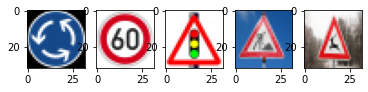

In [12]:
# Preview of inputs
f, axarr = plt.subplots(1,5)
for i in range(len(img_gallary)):
    axarr[i].imshow(img_gallary[i])
plt.show()

In [13]:
# Reset tf model
tf.reset_default_graph()

In [14]:
# tf inputs
#Input image batch
x = tf.placeholder(tf.float32, (None, 32, 32, 3))

#Input label batch
y = tf.placeholder(tf.int32, (None))
rate = 0
#Encoding 
one_hot_y = tf.one_hot(y, 44)

#items will retrive from metadata
logits = LeNet(x)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Predict and anlyze the Sign Type

In [15]:
# Testing
with tf.Session() as sess:
    # Loading trained model
    saver.restore(sess, "./lenet")
    print("Load completed")

    #Check accuracy
    accuracy = sess.run(accuracy_operation, feed_dict={x: input4d, y: labels})
    eva_accuracy = evaluate(input4d,labels)
    print("Accuracy = {:.2f}".format(accuracy))
    
    #Show top 5 predicted probabilities
    predict = sess.run(logits, feed_dict={x: input4d, y: labels})
    prob = tf.nn.softmax(predict).eval()
    pre = sess.run(tf.nn.top_k(tf.constant(predict), k=5))
pre # correct labels = [40,3,26,25,31]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet
Load completed
Accuracy = 1.00


TopKV2(values=array([[54.298904 ,  4.5612364,  4.298113 ,  3.9381204,  2.8242397],
       [65.319176 , 42.708042 , 26.91466  , 20.300241 , 14.609289 ],
       [72.14211  , 39.50404  , 13.078166 ,  5.2762575, -5.082942 ],
       [14.95472  , 13.254501 , 10.454136 ,  6.2248917,  5.1671443],
       [24.367895 , 15.914775 , 13.052671 ,  2.7882955,  2.3819535]],
      dtype=float32), indices=array([[40,  8,  5, 35, 12],
       [ 3,  2, 13,  5, 15],
       [26, 18, 17, 29, 14],
       [25, 24, 29, 22, 31],
       [31, 23, 25, 10, 21]], dtype=int32))